In [37]:
import  numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [38]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size':14})
pd.set_option('display.float_format', lambda x:'%.3f' % x)

In [39]:
def evaluate_preds(true_values_train, pred_values_train, true_values_test, pred_values_test):
    print('Train:\t' + 'R2 = ' + str(round(r2_score(true_values_train, pred_values_train), 3)) +
          '\tMAE = ' + str(int(mean_absolute_error(true_values_train, pred_values_train))) +
          '\n' +
          'Test:\t' + 'R2 = ' + str(round(r2_score(true_values_test, pred_values_test), 3)) +
          '\tMAE = ' + str(int(mean_absolute_error(true_values_test, pred_values_test)))
         )

    plt.figure(figsize=(16, 6))

    plt.subplot(121)
    sns.scatterplot(x=pred_values_train, y=true_values_train)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train: True vs Predicted values');

    plt.subplot(122)
    sns.scatterplot(x=pred_values_test, y=true_values_test)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test: True vs Predicted values');

In [40]:
PREPARED_DATASET_PATH = 'housing_prepared.csv'
TRAIN_DATASET_PATH = 'housing_train.csv'
SCALER_FILE_PATH = 'scaler.pkl'
MODEL_FILE_PATH = 'model.pkl'

In [41]:
df = pd.read_csv(PREPARED_DATASET_PATH)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,rooms_per_household,bedrooms_per_household,persons_per_household,income_per_person
0,-122.230,37.880,41.000,880.000,129.000,322.000,126.000,8.325,452600.000,NEAR BAY,0,0,1,0,6.984,1.024,2.556,258.547
1,-122.220,37.860,21.000,7099.000,1106.000,2401.000,1138.000,8.301,358500.000,NEAR BAY,0,0,1,0,6.238,0.972,2.110,34.575
2,-122.240,37.850,52.000,1467.000,190.000,496.000,177.000,7.257,352100.000,NEAR BAY,0,0,1,0,8.288,1.073,2.802,146.319
3,-122.250,37.850,52.000,1274.000,235.000,558.000,219.000,5.643,341300.000,NEAR BAY,0,0,1,0,5.817,1.073,2.548,101.131
4,-122.250,37.850,52.000,1627.000,280.000,565.000,259.000,3.846,342200.000,NEAR BAY,0,0,1,0,6.282,1.081,2.181,68.074


In [42]:
df.isna().sum()

longitude                 0
latitude                  0
housing_median_age        0
total_rooms               0
total_bedrooms            0
population                0
households                0
median_income             0
median_house_value        0
ocean_proximity           0
<1H OCEAN                 0
INLAND                    0
NEAR BAY                  0
NEAR OCEAN                0
rooms_per_household       0
bedrooms_per_household    0
persons_per_household     0
income_per_person         0
dtype: int64

In [43]:
X = df
y = df['median_house_value']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, shuffle=True, random_state=42,)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15476, 18) (15476,)
(5159, 18) (5159,)


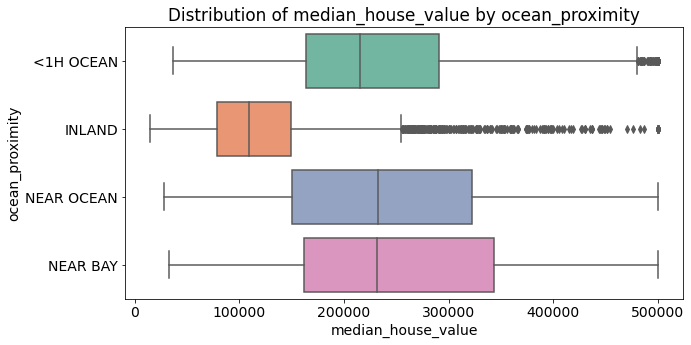

In [45]:
plt.figure(figsize=(10, 5))
sns.boxplot(X_train['median_house_value'], X_train['ocean_proximity'], palette='Set2', )
plt.xlabel('median_house_value')
plt.ylabel('ocean_proximity')
plt.title('Distribution of median_house_value by ocean_proximity');

In [46]:
house_values_gr = X_train.groupby('ocean_proximity')['median_house_value'].median()
house_values_gr

ocean_proximity
<1H OCEAN    215350.000
INLAND       108800.000
NEAR BAY     231850.000
NEAR OCEAN   232100.000
Name: median_house_value, dtype: float64

In [47]:
X_train = X_train.merge(house_values_gr, on='ocean_proximity', how='left', suffixes=['','_gr'])
X_test = X_test.merge(house_values_gr, on='ocean_proximity', how='left', suffixes=['','_gr'])

X_train.drop('ocean_proximity', axis=1, inplace=True)
X_test.drop('ocean_proximity', axis=1, inplace=True)
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,NEAR BAY,NEAR OCEAN,rooms_per_household,bedrooms_per_household,persons_per_household,income_per_person,median_house_value_gr
0,-122.700,38.440,45.000,883.000,202.000,401.000,194.000,3.284,178300.000,1,0,0,0,4.552,1.041,2.067,81.908,215350.000
1,-118.410,34.160,32.000,3060.000,505.000,1159.000,510.000,6.370,465800.000,1,0,0,0,6.000,0.990,2.273,54.964,215350.000
2,-121.760,38.550,23.000,8800.000,1857.000,6330.000,1832.000,2.065,219400.000,0,1,0,0,4.803,1.014,3.455,3.262,108800.000
3,-117.140,32.710,52.000,979.000,314.000,975.000,297.000,1.238,100000.000,0,0,0,1,3.296,1.057,3.283,12.692,232100.000
4,-122.120,37.410,33.000,2892.000,617.000,1250.000,581.000,5.373,360900.000,0,0,1,0,4.978,1.062,2.151,42.982,231850.000


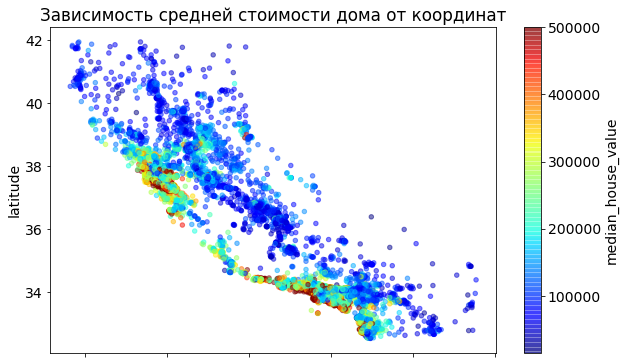

In [48]:
X_train.plot(kind='scatter', x='longitude', y='latitude', alpha=0.5,
             c='median_house_value', cmap=plt.get_cmap('jet'), figsize=(10, 6))
plt.title("Зависимость средней стоимости дома от координат");

In [49]:
SF_coord = [-122.41942, 37.77493]
LA_coord = [-118.24368, 34.05223]

X_train['dist_to_SF'] = np.sqrt((X_train['longitude'] - SF_coord[0])**2 +
                                (X_train['latitude'] - SF_coord[1])**2)
X_test['dist_to_SF'] = np.sqrt((X_test['longitude'] - SF_coord[0])**2 +
                               (X_test['latitude'] - SF_coord[1])**2)

X_train['dist_to_LA'] = np.sqrt((X_train['longitude'] - LA_coord[0])**2 +
                                (X_train['latitude'] - LA_coord[1])**2)
X_test['dist_to_LA'] = np.sqrt((X_test['longitude'] - LA_coord[0])**2 +
                               (X_test['latitude'] - LA_coord[1])**2)

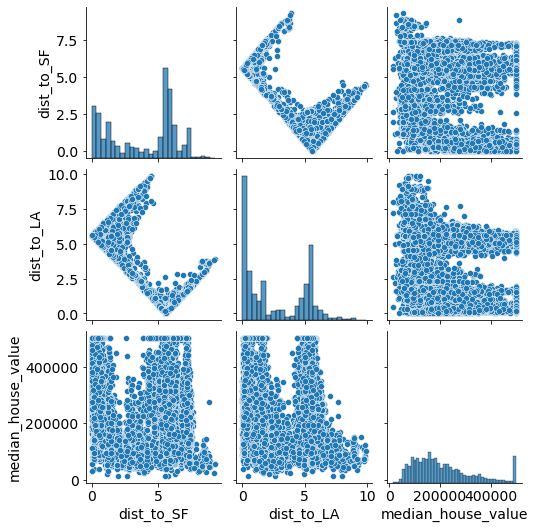

In [50]:
sns.pairplot(X_train[['dist_to_SF', 'dist_to_LA', 'median_house_value']])

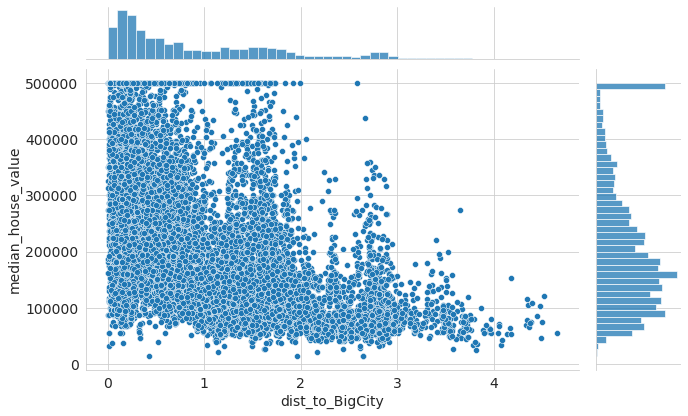

In [51]:
X_train['dist_to_BigCity'] = X_train[['dist_to_SF', 'dist_to_LA']].min(axis=1)
X_test['dist_to_BigCity'] = X_test[['dist_to_SF', 'dist_to_LA']].min(axis=1)
with sns.axes_style(style='whitegrid'):
    grid = sns.jointplot(X_train['dist_to_BigCity'], X_train['median_house_value'],
                         kind='scatter')
grid.fig.set_figwidth(10)
grid.fig.set_figheight(6)

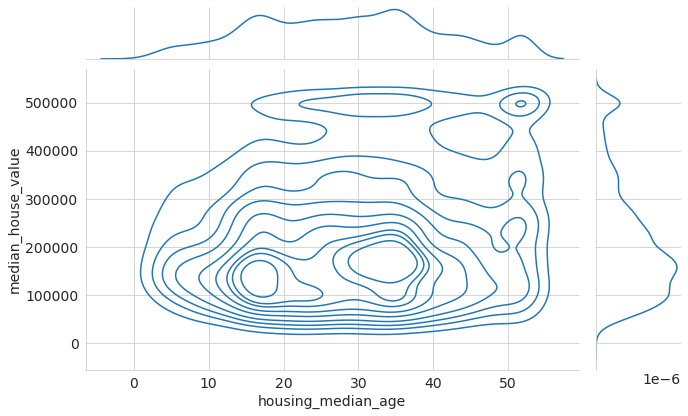

In [52]:
with sns.axes_style(style='whitegrid'):
    grid = sns.jointplot(X_train['housing_median_age'], X_train['median_house_value'], kind='kde')
grid.fig.set_figwidth(10)
grid.fig.set_figheight(6)

In [53]:
bins = [0, 25, 40, 60]
labels = ["age<25", "25>age>40", "age>40"]

X_train['age_cat'] = pd.cut(X_train['housing_median_age'], bins=bins, labels=labels)
X_test['age_cat'] = pd.cut(X_test['housing_median_age'], bins=bins, labels=labels)

X_train['age_cat'].value_counts()

age<25       6435
25>age>40    6225
age>40       2816
Name: age_cat, dtype: int64

In [54]:
X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,...,NEAR OCEAN,rooms_per_household,bedrooms_per_household,persons_per_household,income_per_person,median_house_value_gr,dist_to_SF,dist_to_LA,dist_to_BigCity,age_cat
0,-122.700,38.440,45.000,883.000,202.000,401.000,194.000,3.284,178300.000,1,...,0,4.552,1.041,2.067,81.908,215350.000,0.722,6.254,0.722,age>40
1,-118.410,34.160,32.000,3060.000,505.000,1159.000,510.000,6.370,465800.000,1,...,0,6.000,0.990,2.273,54.964,215350.000,5.398,0.198,0.198,25>age>40
2,-121.760,38.550,23.000,8800.000,1857.000,6330.000,1832.000,2.065,219400.000,0,...,0,4.803,1.014,3.455,3.262,108800.000,1.018,5.709,1.018,age<25
3,-117.140,32.710,52.000,979.000,314.000,975.000,297.000,1.238,100000.000,0,...,1,3.296,1.057,3.283,12.692,232100.000,7.316,1.738,1.738,age>40
4,-122.120,37.410,33.000,2892.000,617.000,1250.000,581.000,5.373,360900.000,0,...,0,4.978,1.062,2.151,42.982,231850.000,0.472,5.128,0.472,25>age>40


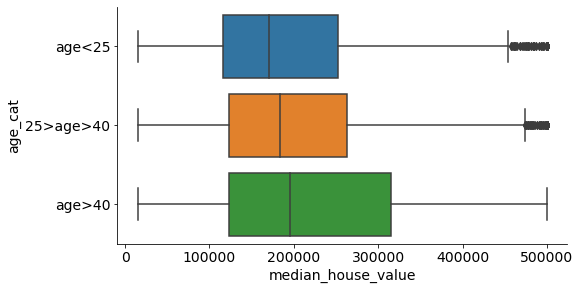

In [55]:
sns.catplot(x='median_house_value', y='age_cat',
            data=X_train, kind="box", size=4, aspect=4/2);

In [56]:
house_values_gr_age = X_train.groupby('age_cat')['median_house_value'].median()
house_values_gr_age

age_cat
age<25      170000.000
25>age>40   183800.000
age>40      195900.000
Name: median_house_value, dtype: float64

In [57]:
X_train = X_train.merge(house_values_gr_age, on='age_cat', how='left', suffixes=['', '_gr_age'])
X_test = X_test.merge(house_values_gr_age, on='age_cat', how='left', suffixes=['', '_gr_age'])

X_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,...,rooms_per_household,bedrooms_per_household,persons_per_household,income_per_person,median_house_value_gr,dist_to_SF,dist_to_LA,dist_to_BigCity,age_cat,median_house_value_gr_age
0,-122.700,38.440,45.000,883.000,202.000,401.000,194.000,3.284,178300.000,1,...,4.552,1.041,2.067,81.908,215350.000,0.722,6.254,0.722,age>40,195900.000
1,-118.410,34.160,32.000,3060.000,505.000,1159.000,510.000,6.370,465800.000,1,...,6.000,0.990,2.273,54.964,215350.000,5.398,0.198,0.198,25>age>40,183800.000
2,-121.760,38.550,23.000,8800.000,1857.000,6330.000,1832.000,2.065,219400.000,0,...,4.803,1.014,3.455,3.262,108800.000,1.018,5.709,1.018,age<25,170000.000
3,-117.140,32.710,52.000,979.000,314.000,975.000,297.000,1.238,100000.000,0,...,3.296,1.057,3.283,12.692,232100.000,7.316,1.738,1.738,age>40,195900.000
4,-122.120,37.410,33.000,2892.000,617.000,1250.000,581.000,5.373,360900.000,0,...,4.978,1.062,2.151,42.982,231850.000,0.472,5.128,0.472,25>age>40,183800.000


In [58]:
X_train.drop('age_cat', axis=1, inplace=True)
X_test.drop('age_cat', axis=1, inplace=True)

In [59]:
feature_skewed_names = ['households','median_income','population', 'total_bedrooms',
                        'total_rooms', 'rooms_per_household', 'bedrooms_per_household',
                        'persons_per_household', 'income_per_person']
feature_log_names = []
for f in feature_skewed_names:
    X_train[f + '_log'] = np.log(X_train[f])
    X_test[f + '_log'] = np.log(X_test[f])
    feature_log_names.append(f + '_log')

In [60]:
feature_num_names = X_train.select_dtypes(include='float64').columns.tolist()
feature_num_names

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'rooms_per_household',
 'bedrooms_per_household',
 'persons_per_household',
 'income_per_person',
 'median_house_value_gr',
 'dist_to_SF',
 'dist_to_LA',
 'dist_to_BigCity',
 'median_house_value_gr_age',
 'households_log',
 'median_income_log',
 'population_log',
 'total_bedrooms_log',
 'total_rooms_log',
 'rooms_per_household_log',
 'bedrooms_per_household_log',
 'persons_per_household_log',
 'income_per_person_log']

In [61]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[feature_num_names]), columns=feature_num_names, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.fit(X_test[feature_num_names]), columns=feature_num_names, index=X_test.index)

In [62]:
X_train_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,15476.000,0.000,1.000,-2.379,-1.113,0.538,0.782,2.547
latitude,15476.000,0.000,1.000,-1.452,-0.796,-0.646,0.973,2.954
housing_median_age,15476.000,0.000,1.000,-2.232,-0.778,0.029,0.675,1.886
total_rooms,15476.000,0.000,1.000,-1.218,-0.549,-0.233,0.240,16.260
total_bedrooms,15476.000,-0.000,1.000,-1.281,-0.577,-0.247,0.259,14.096
population,15476.000,0.000,1.000,-1.249,-0.552,-0.227,0.245,30.108
households,15476.000,-0.000,1.000,-1.306,-0.579,-0.236,0.277,14.603
median_income,15476.000,0.000,1.000,-1.770,-0.688,-0.180,0.460,5.818
median_house_value,15476.000,-0.000,1.000,-1.663,-0.758,-0.239,0.505,2.532
rooms_per_household,15476.000,0.000,1.000,-1.856,-0.403,-0.083,0.256,55.609


In [63]:
X_test_scaled.describe().T

,count,unique,top,freq
longitude,5159,1,StandardScaler(),5159
latitude,5159,1,StandardScaler(),5159
housing_median_age,5159,1,StandardScaler(),5159
total_rooms,5159,1,StandardScaler(),5159
total_bedrooms,5159,1,StandardScaler(),5159
population,5159,1,StandardScaler(),5159
households,5159,1,StandardScaler(),5159
median_income,5159,1,StandardScaler(),5159
median_house_value,5159,1,StandardScaler(),5159
rooms_per_household,5159,1,StandardScaler(),5159


In [64]:
feature_bin_names = X_train.select_dtypes(include='int64').columns.tolist()
feature_bin_names

['<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN']

In [65]:
X_train_scaled[feature_bin_names] = X_train[feature_bin_names]
X_test_scaled[feature_bin_names] = X_test[feature_bin_names]

In [66]:
X_train_scaled.to_csv(TRAIN_DATASET_PATH, index=False, encoding='utf-8')
X_train.shape, X_train_scaled.shape

((15476, 31), (15476, 31))

In [67]:
X_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', '<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN',
       'rooms_per_household', 'bedrooms_per_household',
       'persons_per_household', 'income_per_person', 'median_house_value_gr',
       'dist_to_SF', 'dist_to_LA', 'dist_to_BigCity',
       'median_house_value_gr_age', 'households_log', 'median_income_log',
       'population_log', 'total_bedrooms_log', 'total_rooms_log',
       'rooms_per_household_log', 'bedrooms_per_household_log',
       'persons_per_household_log', 'income_per_person_log'],
      dtype='object')

In [68]:
feature_names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                 'total_bedrooms', 'population', 'households', 'median_income']

In [69]:
lr_model = LinearRegression()
lr_model.fit(X_train[feature_names], y_train)

LinearRegression()

Train:	R2 = 0.634	MAE = 51262
Test:	R2 = 0.62	MAE = 51174


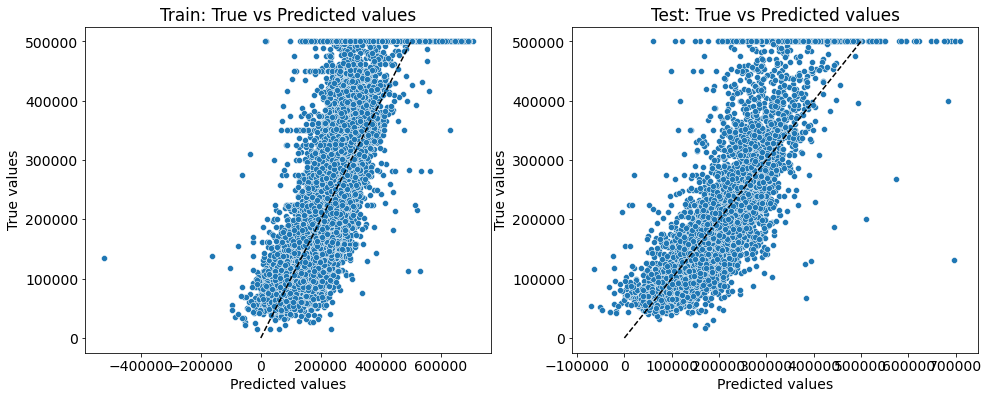

In [70]:
y_train_preds = lr_model.predict(X_train[feature_names])
y_test_preds = lr_model.predict(X_test[feature_names])

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [71]:
pd.DataFrame({"Feature":feature_names,"Coefficients":lr_model.coef_.flatten().T})

,Feature,Coefficients
0,longitude,-41963.017
1,latitude,-41755.430
2,housing_median_age,1165.318
3,total_rooms,-8.737
4,total_bedrooms,109.444
5,population,-31.876
6,households,36.504
7,median_income,40532.945


In [72]:
lr_model.fit(X_train_scaled[feature_names], y_train)

y_train_preds = lr_model.predict(X_train_scaled[feature_names])
y_test_preds = lr_model.predict(X_test_scaled[feature_names])

# Постпроцессинг
y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500001)
y_test_preds = np.clip(y_test_preds, a_min=10000, a_max=500001)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

TypeError: float() argument must be a string or a number, not 'StandardScaler'

In [73]:
pd.DataFrame({"Feature":feature_names,"Coefficients":lr_model.coef_.flatten().T})

,Feature,Coefficients
0,longitude,-84157.429
1,latitude,-89192.942
2,housing_median_age,14432.340
3,total_rooms,-18962.641
4,total_bedrooms,45856.651
5,population,-36269.826
6,households,13950.903
7,median_income,77457.471


Train:	R2 = 0.671	MAE = 48230
Test:	R2 = 0.65	MAE = 48294


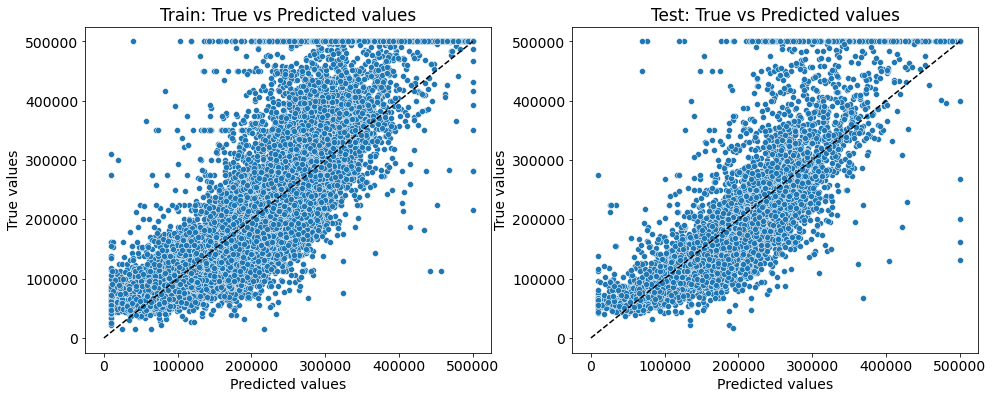

In [74]:
feature_names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                 'total_bedrooms', 'population', 'households', 'median_income',
                 '<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN',
                 'rooms_per_household', 'bedrooms_per_household',
                 'persons_per_household', 'income_per_person', 'median_house_value_gr',
                 'dist_to_SF', 'dist_to_LA', 'dist_to_BigCity',
                 'median_house_value_gr_age']
lr_model.fit(X_train[feature_names], y_train)

y_train_preds = lr_model.predict(X_train[feature_names])
y_test_preds = lr_model.predict(X_test[feature_names])

# Постпроцессинг
y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500001)
y_test_preds = np.clip(y_test_preds, a_min=10000, a_max=500001)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)
# Train:R2 = 0.634	MAE = 51262
# Test: R2 = 0.62	MAE = 51174

Train:	R2 = 0.692	MAE = 46399
Test:	R2 = 0.668	MAE = 46859


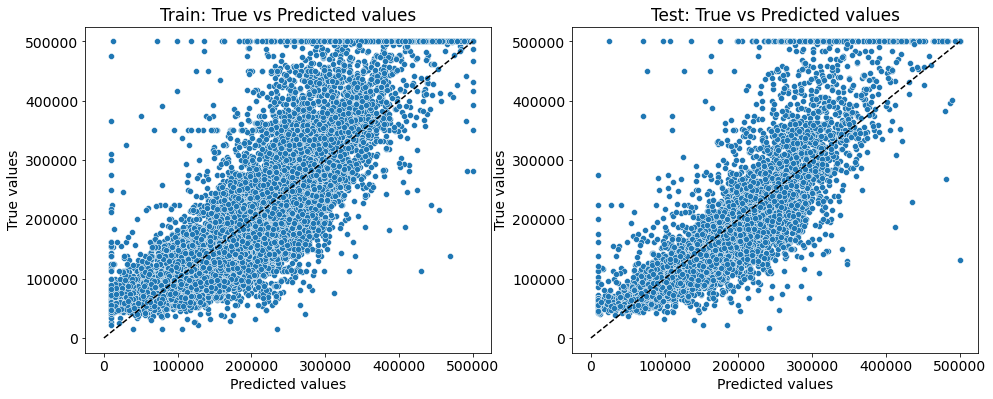

In [75]:
feature_names = ['longitude', 'latitude', 'housing_median_age', 'total_rooms',
                 'total_bedrooms', 'population', 'households', 'median_income',
                 '<1H OCEAN', 'INLAND', 'NEAR BAY', 'NEAR OCEAN',
                 'rooms_per_household', 'bedrooms_per_household',
                 'persons_per_household', 'income_per_person', 'median_house_value_gr',
                 'dist_to_SF', 'dist_to_LA', 'dist_to_BigCity',
                 'median_house_value_gr_age', 'households_log', 'median_income_log',
                 'population_log', 'total_bedrooms_log', 'total_rooms_log',
                 'rooms_per_household_log', 'bedrooms_per_household_log',
                 'persons_per_household_log', 'income_per_person_log']
lr_model.fit(X_train[feature_names], y_train)

y_train_preds = lr_model.predict(X_train[feature_names])
y_test_preds = lr_model.predict(X_test[feature_names])

# Постпроцессинг
y_train_preds = np.clip(y_train_preds, a_min=10000, a_max=500001)
y_test_preds = np.clip(y_test_preds, a_min=10000, a_max=500001)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [76]:
X = pd.concat([X_train[feature_names], X_test[feature_names]])
y = np.concatenate((y_train, y_test))
X.shape, y.shape

((20635, 30), (20635,))

In [77]:
cv = KFold(n_splits=5, random_state=42, shuffle=True)

scores = cross_val_score(lr_model, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(scores)
print('R2 для линейной регрессии = ', round(scores.mean(), 4))

[0.67155903 0.66224494 0.66448098 0.66812665 0.6666883 ]
R2 для линейной регрессии =  0.6666


Train:	R2 = 1.0	MAE = 0
Test:	R2 = 0.619	MAE = 44363
R2 для решающего дерева =  0.6542


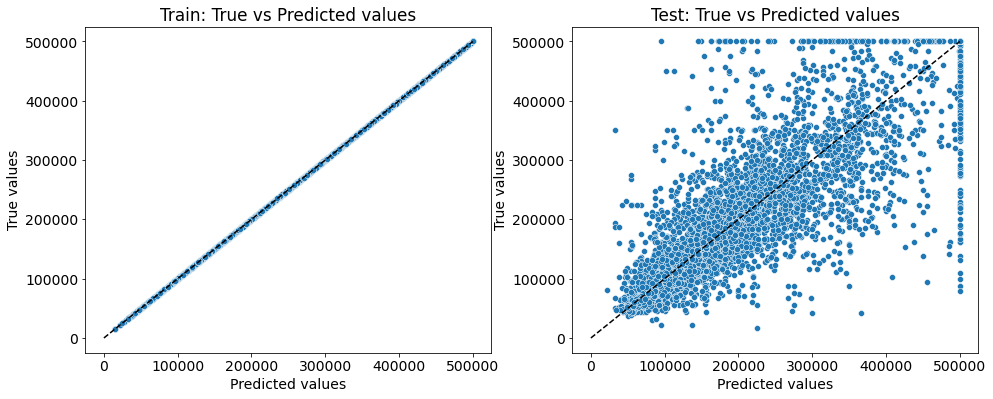

In [78]:
dt_model = DecisionTreeRegressor(random_state=42)

dt_model.fit(X_train[feature_names], y_train)
y_train_preds = dt_model.predict(X_train[feature_names])
y_test_preds = dt_model.predict(X_test[feature_names])

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

scores = cross_val_score(dt_model, X, y, cv=cv, scoring='r2', n_jobs=-1)
print('R2 для решающего дерева = ', round(scores.mean(), 4))

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15476, 30) (15476,)
(5159, 30) (5159,)


Train:	R2 = 0.975	MAE = 11659
Test:	R2 = 0.825	MAE = 31297
R2 для случайного леса =  0.6542


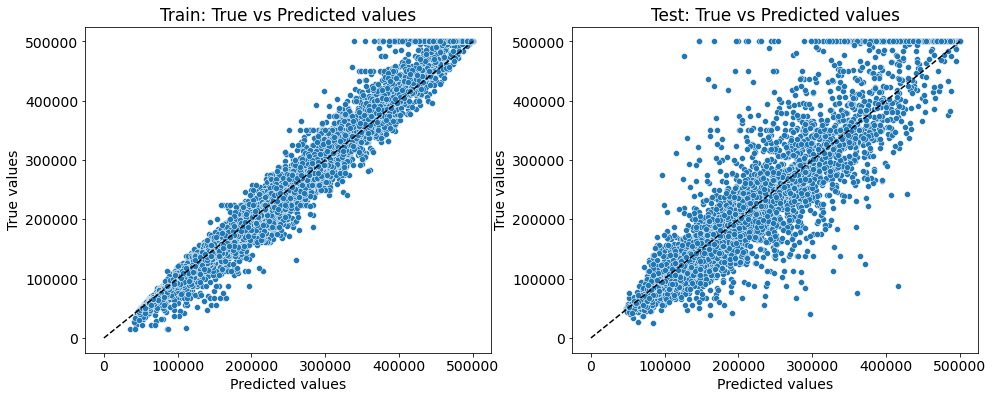

In [80]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

scores = cross_val_score(dt_model, X, y, cv=cv, scoring='r2', n_jobs=-1)
print('R2 для случайного леса = ', round(scores.mean(), 4))

In [82]:
scores = cross_val_score(rf_model, X, y, cv=cv, scoring='r2', n_jobs=-1)
print('R2 для случайного леса = ', round(scores.mean(), 4))

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


Train:	R2 = 0.816	MAE = 34067
Test:	R2 = 0.804	MAE = 35325


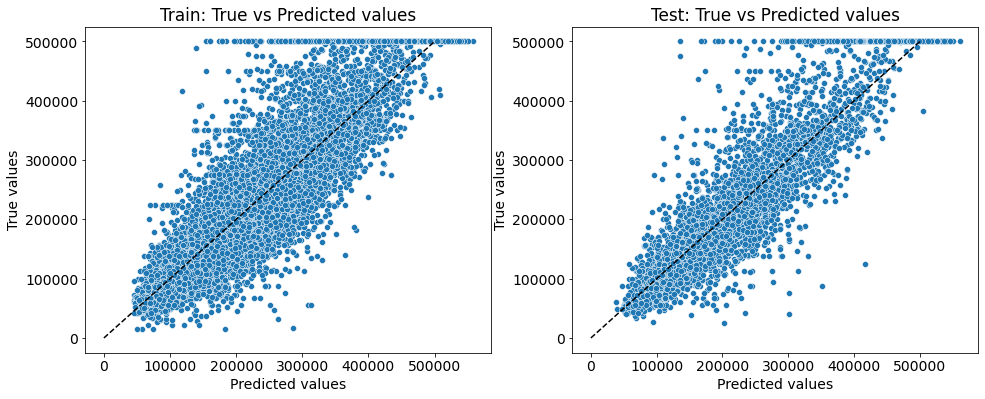

In [83]:
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

In [84]:
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [85]:
params = {'n_estimators': [100, 200],
          'max_depth': [6, 7, 8]}

gs = GridSearchCV(gb_model, params, scoring='r2',
                  cv=cv, n_jobs=-1)
gs.fit(X, y)
print(gs.best_params_)
print(gs.best_score_)

{'max_depth': 7, 'n_estimators': 200}
0.8455253245998712
